In [1]:
import logging

import jax
import jax.numpy as jnp
import liesel.goose as gs
import plotnine as p9
import tensorflow_probability.substrates.jax.bijectors as tfb

import liesel_ptm as ptm

In [2]:
logger = logging.getLogger("liesel_ptm")
logger.setLevel(logging.DEBUG)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    handler.setLevel(logging.DEBUG)
    logger.addHandler(handler)

In [3]:
# jax.config.update("jax_enable_x64", True)

In [4]:
from pathlib import Path

import dill as pickle

with open(Path.cwd() / ".." / "notebooks" / "y_ridge.pkl", "rb") as fp:
    y = pickle.load(fp)

In [5]:
y = jax.random.normal(jax.random.key(929), (500,))

In [6]:
# y = jnp.r_[y, y, y, y, y,y,y,y,y,y]
# y.shape

In [7]:
# y = jnp.r_[y,y]
# y.shape

In [8]:
nparam = 10
knots = ptm.PTMKnots(a=-4.0, b=4.0, nparam=nparam)

In [9]:
model = ptm.LocScalePTM(y, knots.knots, bspline="ptm", to_float32=False)
kernel_kwargs = {"da_target_accept": 0.9}
model.trafo += ptm.PTMCoef.new_rw1_sumzero(
    knots=knots.knots,
    scale=ptm.ScaleWeibull(
        1.0,
        scale=0.5,
        name="trafo0_scale",
        inference=gs.MCMCSpec(
            gs.NUTSKernel, kernel_group="1", kernel_kwargs=kernel_kwargs
        ),
        bijector=tfb.Exp(),
    ),
    name="trafo0",
    inference=gs.MCMCSpec(gs.NUTSKernel, kernel_group="1", kernel_kwargs=kernel_kwargs),
    diagonalize_penalty=True,
)
model.build()

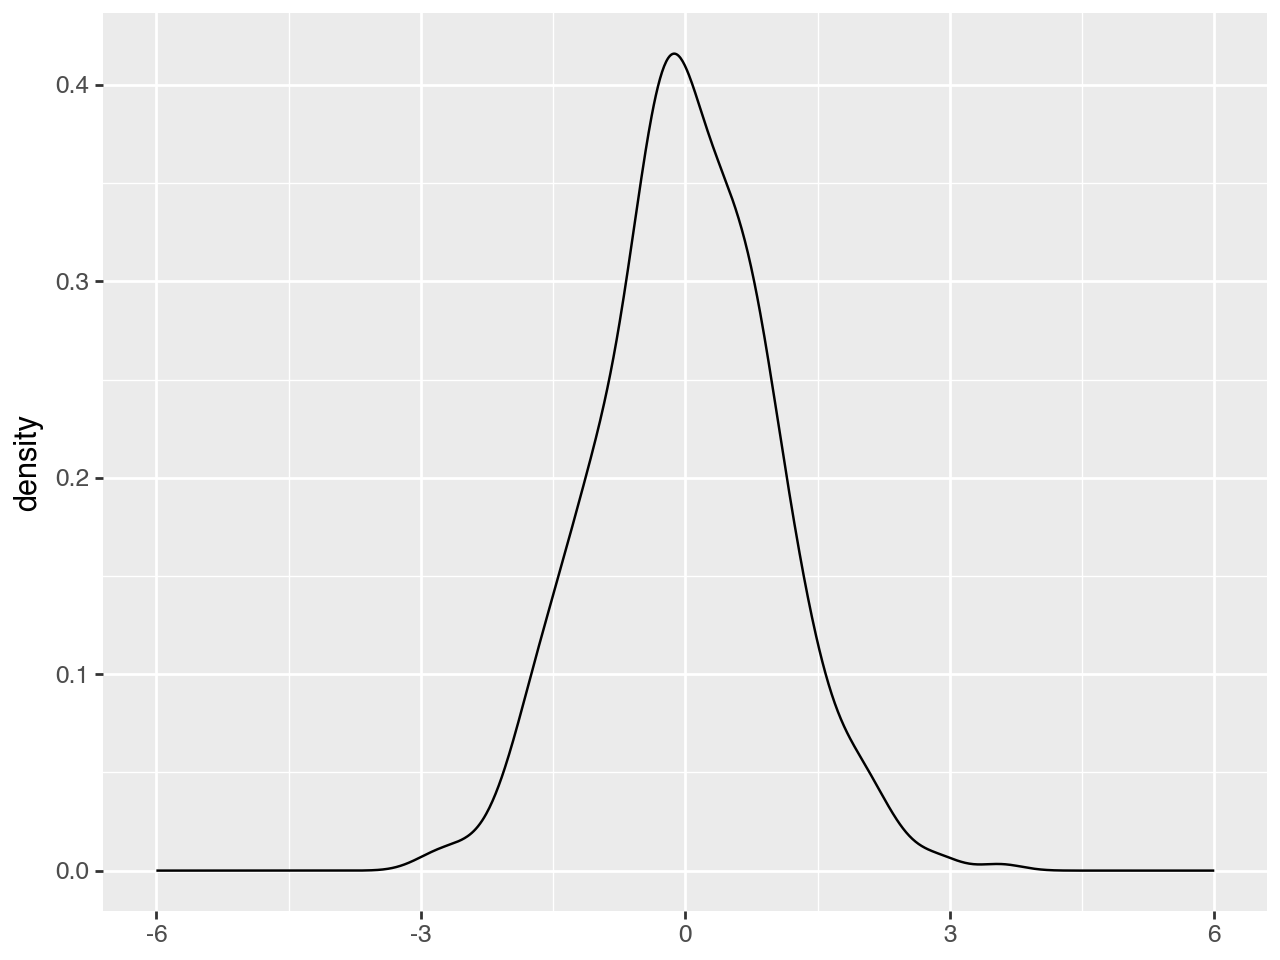

In [10]:
r_sample = model.response.value
(p9.ggplot() + p9.geom_density(p9.aes(r_sample)) + p9.xlim((-6.0, 6.0)))

In [11]:
model.graph.vars["trafo0_scale"].variance_param.value_node[0].value

Array(0., dtype=float32)

In [12]:
model.initialize()
model.setup_default_mcmc_kernels(strategy="iwls-nuts")

2025-09-05 12:09:03,692 - DEBUG - Exlcuding roles: []
2025-09-05 12:09:03,692 - DEBUG - Exlcuding params: ['trafo0_latent', 'trafo0_scale_square_transformed', 'trafo0_latent_transformed', 'trafo0_scale_square_transformed_transformed']
2025-09-05 12:09:03,938 - DEBUG - Optimizing params: ['loc_intercept', 'scale_intercept']
2025-09-05 12:09:03,938 - DEBUG - Optimization step: 0 started
2025-09-05 12:09:05,509 - DEBUG - Optimization step: 0 done
2025-09-05 12:09:05,759 - DEBUG - Exlcuding roles: []
2025-09-05 12:09:05,760 - DEBUG - Exlcuding params: ['scale_intercept', 'loc_intercept', 'scale_intercept_transformed', 'loc_intercept_transformed']
2025-09-05 12:09:05,760 - DEBUG - Setting up temporary bounding for trafo0_scale_square_transformed.
2025-09-05 12:09:05,831 - DEBUG - Saving initial value 0.0 for parametertrafo0_scale_square_transformed.
2025-09-05 12:09:06,109 - DEBUG - Optimizing params: ['trafo0_scale_square_transformed_transformed', 'trafo0_latent']
2025-09-05 12:09:06,109 -

In [14]:
results = model.run_mcmc(
    seed=2,
    warmup=1000,
    posterior=500,
    strategy="manual",
    warm_start=False,
    apply_jitter=False,
)

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 250 transitions, 25 jitted together
100%|████████████████████████████████████████| 10/10 [00:05<00:00,  1.91chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 2, 1, 2 / 250 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 387.86chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 257.83chunk/s]
liese

KeyboardInterrupt: 

In [ ]:
gs.Summary(results)

/Users/johannesbrachem/Documents/git/liesel_ptm2/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


Parameter summary:

                                          kernel      mean            sd  \
parameter                       index                                      
loc_intercept                   ()     kernel_02 -0.001960  2.328306e-10   
scale_intercept                 ()     kernel_01 -0.009309  1.862645e-09   
trafo0_latent                   (0,)   kernel_00  0.000025  1.179604e-02   
                                (1,)   kernel_00 -0.000021  2.866268e-02   
                                (2,)   kernel_00 -0.003448  3.603969e-02   
                                (3,)   kernel_00  0.010775  4.053163e-02   
                                (4,)   kernel_00  0.000681  3.976667e-02   
                                (5,)   kernel_00 -0.005727  4.253292e-02   
                                (6,)   kernel_00  0.002536  4.567213e-02   
                                (7,)   kernel_00 -0.006330  5.374710e-02   
                                (8,)   kernel_00 -0.003173  4.477540e-02   
trafo0_scale_square_transformed ()     kernel_00 -7.110044  1.325391e+00   

                                         q_0.05     q_0.5    q_0.95  \
parameter                       index                                 
loc_intercept                   ()    -0.001960 -0.001960 -0.001960   
scale_intercept                 ()    -0.009309 -0.009309 -0.009309   
trafo0_latent                   (0,)  -0.019351  0.000587  0.018454   
                                (1,)  -0.046465  0.001130  0.045222   
                                (2,)  -0.062765 -0.001918  0.047246   
                                (3,)  -0.042227  0.006314  0.077025   
                                (4,)  -0.063949  0.001452  0.054211   
                                (5,)  -0.069038 -0.002988  0.053781   
                                (6,)  -0.057989  0.000144  0.075658   
                                (7,)  -0.074571 -0.002902  0.062062   
                                (8,)  -0.076357 -0.001023  0.059932   
trafo0_scale_square_transformed ()    -9.007782 -7.191438 -4.936222   

                                       sample_size     ess_bulk     ess_tail  \
parameter                       index                                          
loc_intercept                   ()            1000  1000.000000  1000.000000   
scale_intercept                 ()            1000  1000.000000  1000.000000   
trafo0_latent                   (0,)          1000   861.033117   394.774962   
                                (1,)          1000   978.647540   770.221225   
                                (2,)          1000   828.829345   346.392329   
                                (3,)          1000  1054.412283   436.175660   
                                (4,)          1000   836.983677   635.448927   
                                (5,)          1000   917.823640   564.440841   
                                (6,)          1000  1005.263151   618.975929   
                                (7,)          1000  1011.869666   451.908811   
                                (8,)          1000   690.914935   471.354753   
trafo0_scale_square_transformed ()            1000   150.673580   423.194773   

                                           rhat  
parameter                       index            
loc_intercept                   ()          NaN  
scale_intercept                 ()          NaN  
trafo0_latent                   (0,)   1.007404  
                                (1,)   1.006000  
                                (2,)   1.006103  
                                (3,)   1.012638  
                                (4,)   1.016284  
                                (5,)   1.006993  
                                (6,)   1.009052  
                                (7,)   1.003638  
                                (8,)   1.007371  
trafo0_scale_square_transformed ()     1.015578  

Error summary:

                                                    count relative
kernel    error

In [ ]:
samples = results.get_posterior_samples()

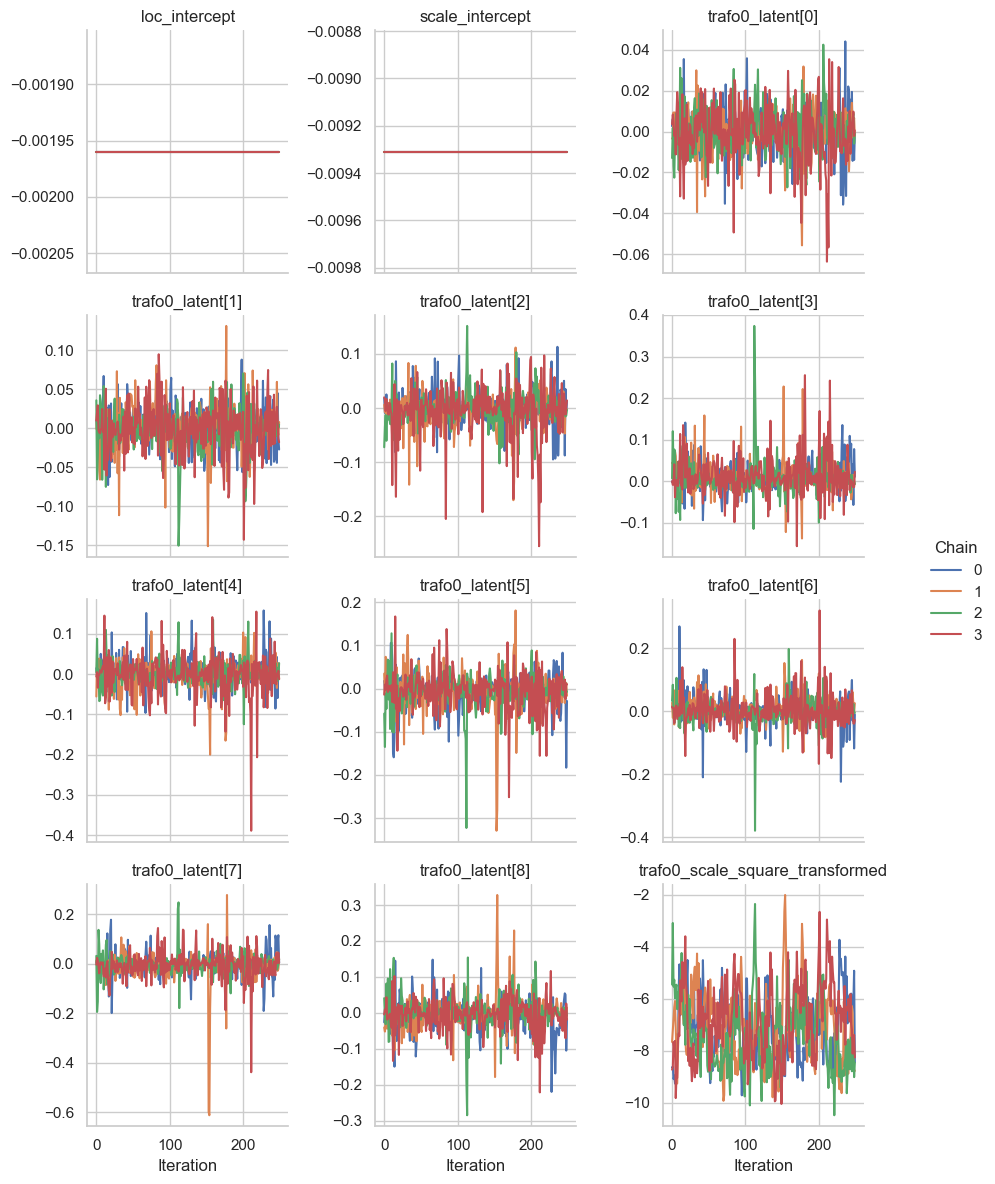

In [ ]:
gs.plot_trace(jax.tree.map(jnp.squeeze, samples))

In [ ]:
dist = model.init_dist(samples, loc=0.0, scale=1.0)
rgrid = jnp.linspace(-6.0, 6.0, 301)
probs = jnp.exp(dist.log_prob(rgrid))
z = dist.transformation_and_logdet(rgrid)[0]

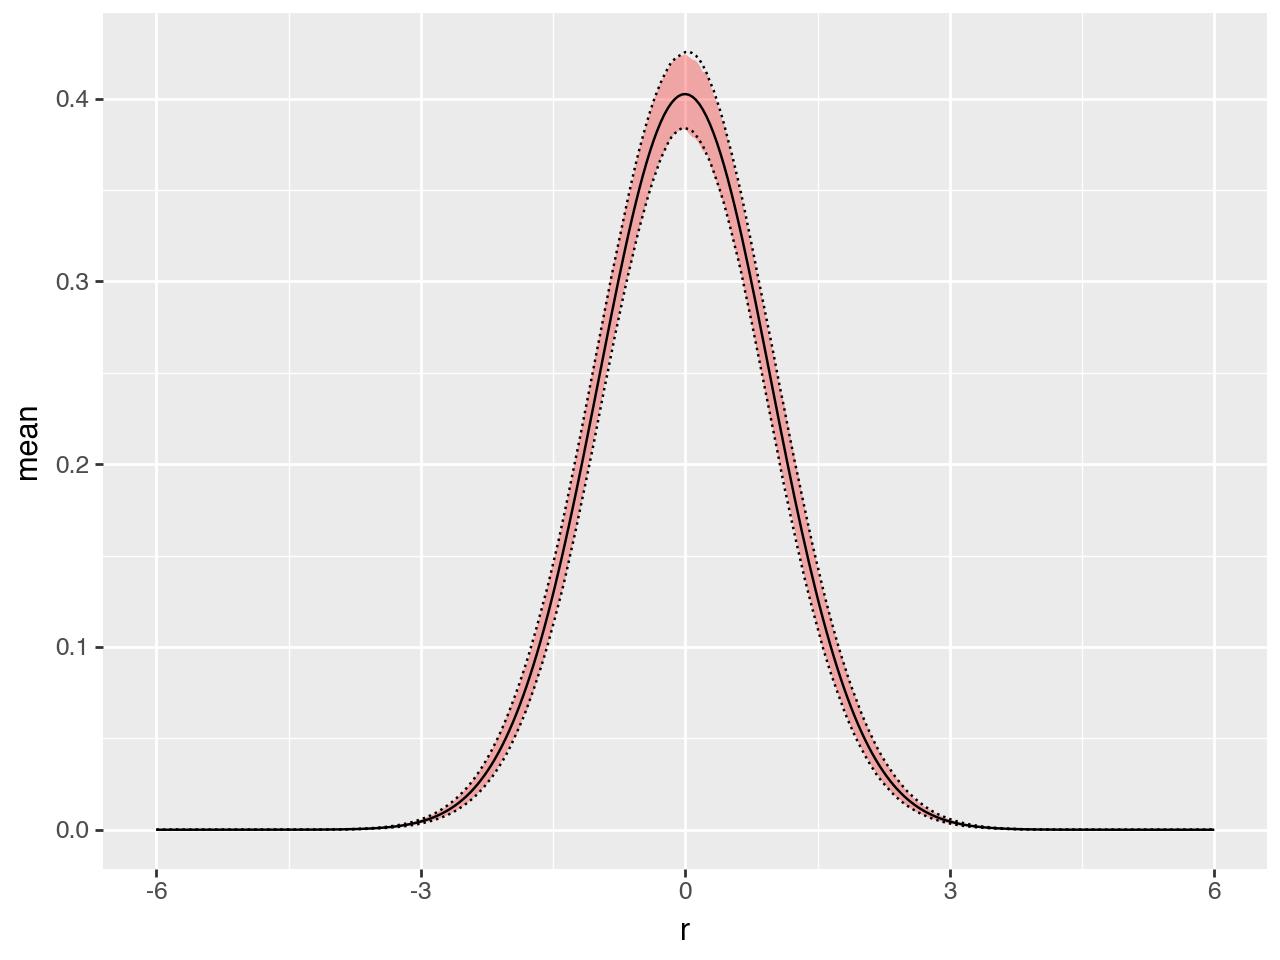

In [ ]:
pdf_summary = gs.SamplesSummary({"pdf": probs}).to_dataframe().reset_index()
pdf_summary["r"] = rgrid

(
    p9.ggplot(pdf_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="red", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
)

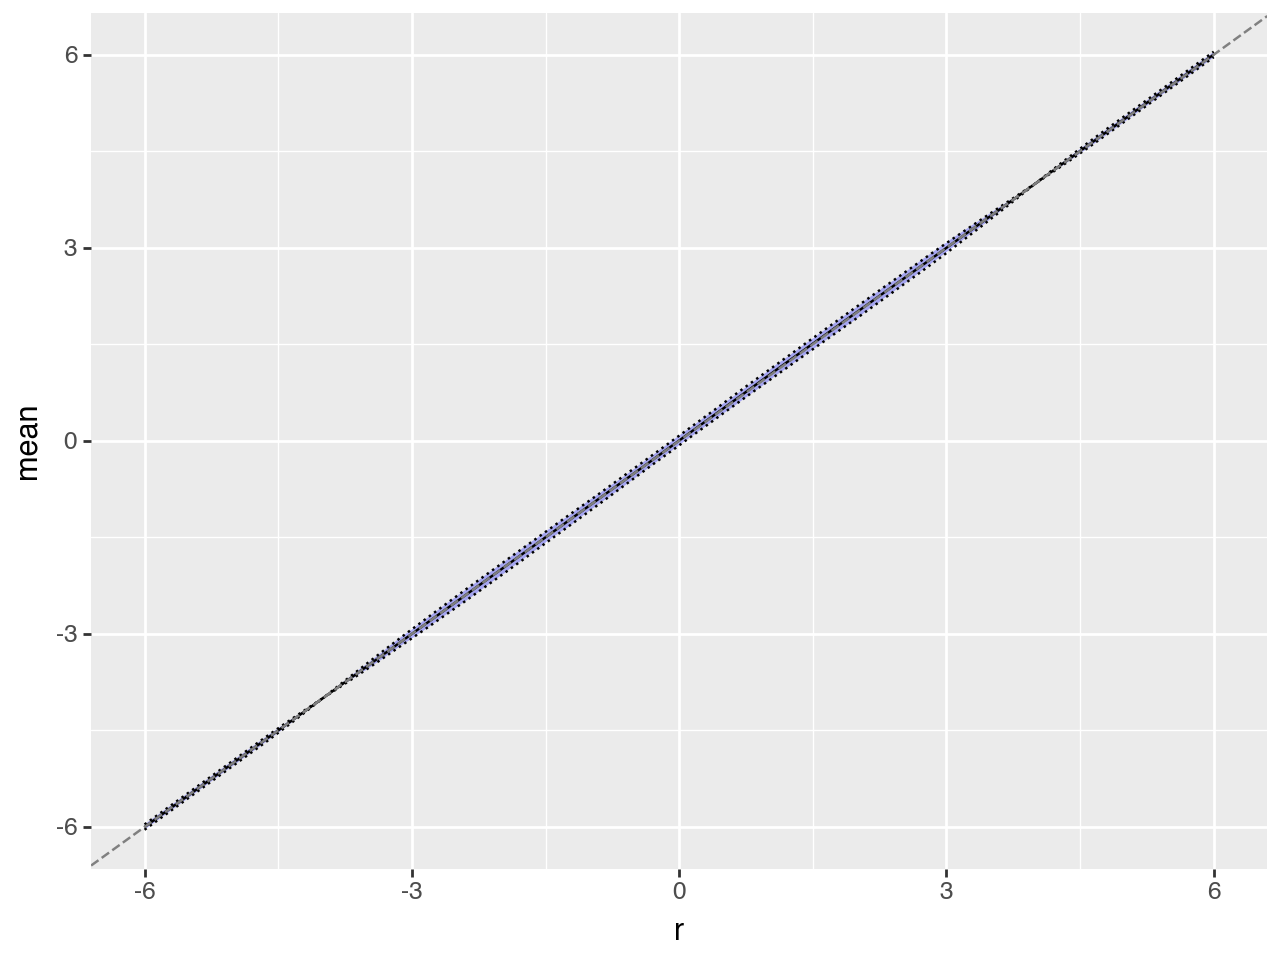

In [ ]:
z_summary = gs.SamplesSummary({"z": z}).to_dataframe().reset_index()
z_summary["r"] = rgrid

(
    p9.ggplot(z_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="blue", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
    + p9.geom_abline(intercept=0.0, slope=1.0, linetype="dashed", color="grey")
)

In [ ]:
pdf_samples = model.summarise_trafo_by_samples(
    jax.random.key(101), grid=rgrid, samples=samples
)
pdf_samples.head()

,z,cdf,pdf,index,obs,chain,sample,r
0,-6.002753,9.699984e-10,5.976319e-09,0,0,3,0,-6.00
1,-5.962753,1.240113e-09,7.592145e-09,1,1,3,0,-5.96
2,-5.922753,1.582981e-09,9.629439e-09,2,2,3,0,-5.92
3,-5.882753,2.017487e-09,1.219388e-08,3,3,3,0,-5.88
4,-5.842753,2.567249e-09,1.541659e-08,4,4,3,0,-5.84


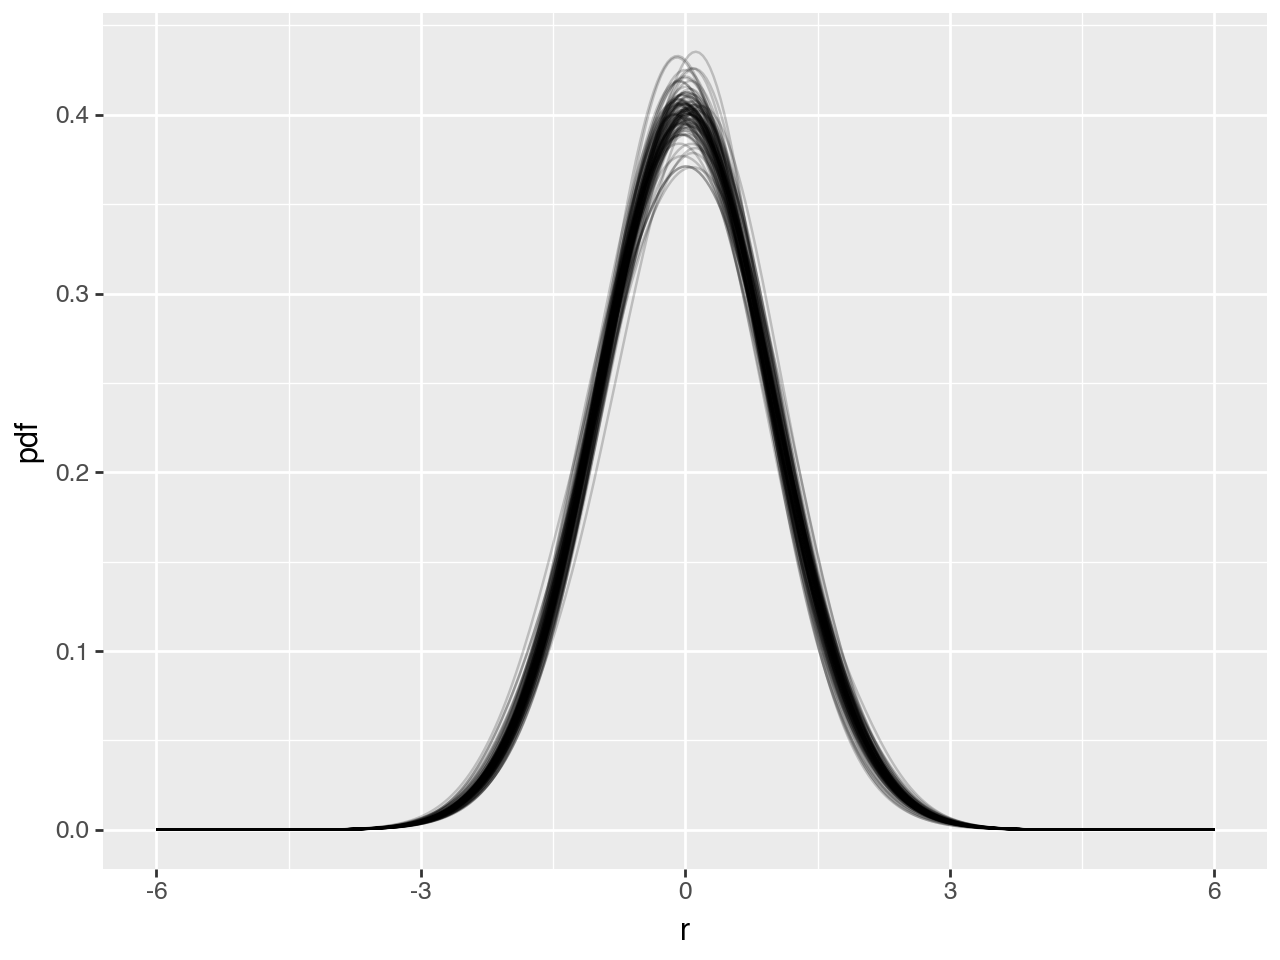

In [ ]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "pdf")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

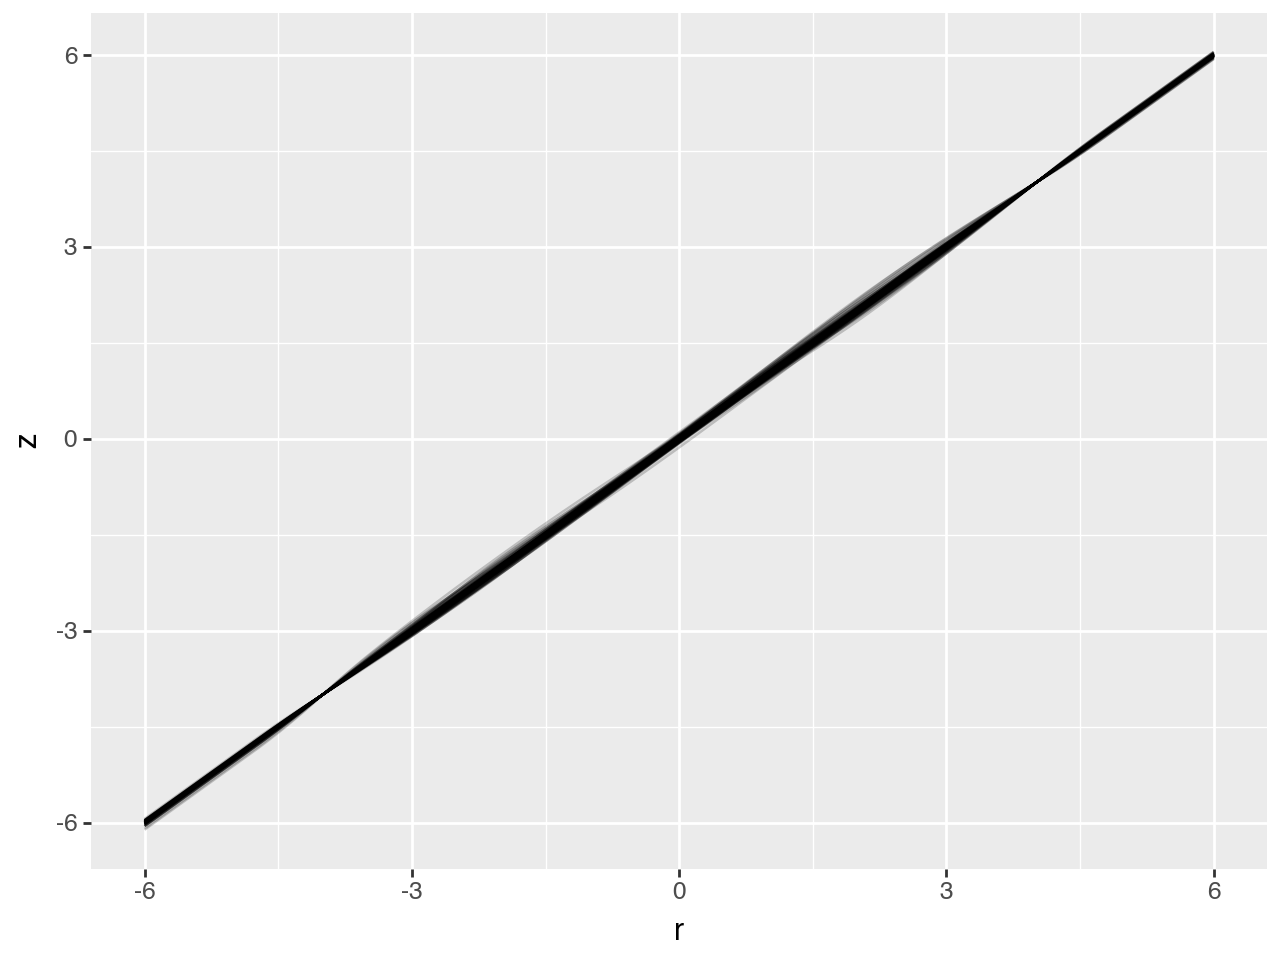

In [ ]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "z")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

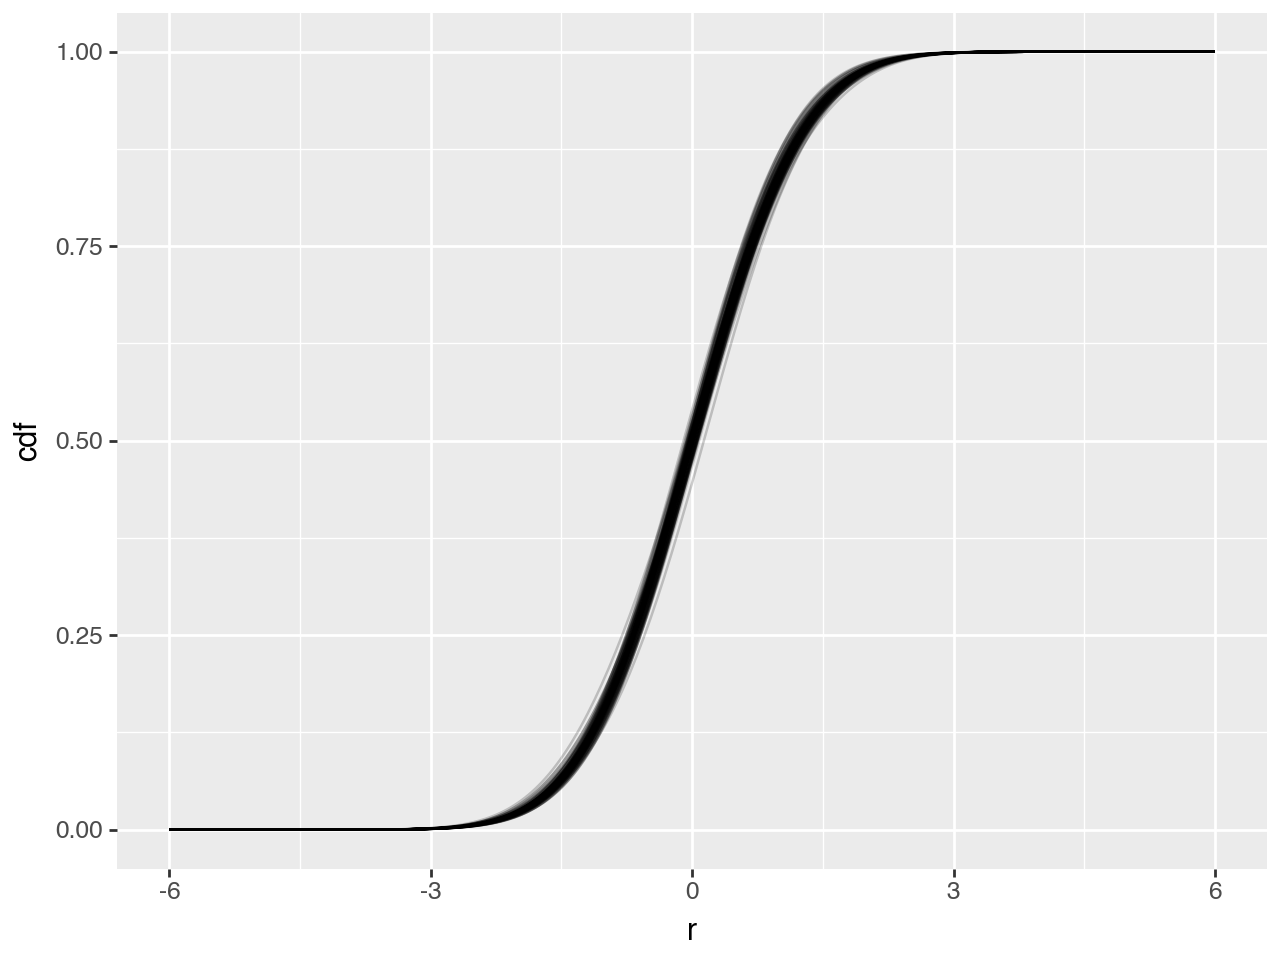

In [ ]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "cdf")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

In [ ]:
meval = ptm.EvaluatePTM(model, samples)
newdata = {"response": y}

In [ ]:
meval.log_score(newdata)

Array(704.6848, dtype=float32)

In [ ]:
meval.waic()

,waic_lppd,waic_elpd,waic_se,waic_p,waic_deviance,n_warning
0,-704.684814,-706.443054,16.737806,1.758261,1412.886108,0


In [ ]:
meval.crps(jnp.array([0.2, 0.3]), newdata)

Array([[[0.01405986, 0.01415341, 0.02511525, ..., 0.05318161,
         0.02052819, 0.03515417],
        [0.01729449, 0.01738804, 0.02834988, ..., 0.05641624,
         0.02376282, 0.02554756],
        [0.0117101 , 0.01180365, 0.02276549, ..., 0.05083185,
         0.01817843, 0.04232042],
        ...,
        [0.01226345, 0.012357  , 0.02331884, ..., 0.05138519,
         0.01873178, 0.04040339],
        [0.01083997, 0.01093352, 0.02189536, ..., 0.04996172,
         0.0173083 , 0.04519529],
        [0.01411817, 0.01421172, 0.02517355, ..., 0.05323991,
         0.02058649, 0.03486457]],

       [[0.01301604, 0.01310959, 0.02407143, ..., 0.05213778,
         0.01948437, 0.03817197],
        [0.01296477, 0.01305832, 0.02402016, ..., 0.05208651,
         0.0194331 , 0.03881235],
        [0.01802858, 0.01812213, 0.02908397, ..., 0.05715033,
         0.02449691, 0.02323487],
        ...,
        [0.01501659, 0.01511014, 0.02607198, ..., 0.05413834,
         0.02148492, 0.03238114],
        [0.0

In [ ]:
meval.wasserstein1(jnp.linspace(0.01, 0.99, num=y.size), newdata).shape

AttributeError: 'EvaluatePTM' object has no attribute 'wasserstein1'

In [ ]:
meval.wasserstein2(jnp.linspace(0.01, 0.99, num=y.size), newdata).shape

(4, 50)

In [ ]:
meval.kld(jnp.linspace(0.01, 0.99, num=y.size), newdata)

Array(2.1697729, dtype=float32)